In [24]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

from tqdm import tqdm
import config

# Task 1: Zero-Shot Classification with Foundation Models

### Objective
The goal of this task is to explore the **EuroSAT dataset** and apply zero-shot classification using a **pre-trained CLIP model**. We will evaluate how well CLIP can classify satellite images using textual descriptions without any dataset-specific training.


## Data: EuroSAT Dataset

### Overview
The **EuroSAT dataset** consists of RGB satellite images categorized into 10 land cover classes. Let's analyze the structure.

Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Modified classes:  ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea or Lake']
Class distribution: {'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}


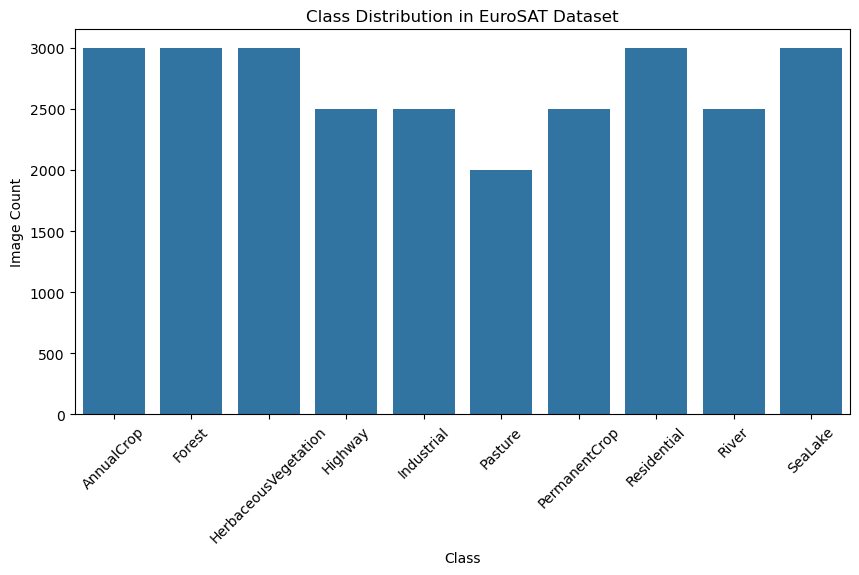

In [13]:
# classes check
dataset_path = "2750/"

classes = sorted([cls for cls in os.listdir(dataset_path) if not cls.startswith('.')])
modified_classes = [config.CLASSNAME_DICT[c] for c in classes]

print(f"Classes found: {classes}")

print("Modified classes: ", modified_classes)

class_counts = {cls: len(glob(os.path.join(dataset_path, cls, "*.jpg"))) for cls in classes}
print(f"Class distribution: {class_counts}")

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Image Count", data=df_counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.show()


In [14]:
# channels and resolution check
image_info = []

for cls in classes:
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]
    img = Image.open(img_path)
    image_info.append((cls, img.mode, img.size))

df_info = pd.DataFrame(image_info, columns=["Class", "Mode", "Resolution"])

print(df_info)

unique_modes = df_info["Mode"].unique()
unique_resolutions = df_info["Resolution"].unique()

print(f"\nUnique image modes found: {unique_modes}")
print(f"Unique image resolutions found: {unique_resolutions}")


                  Class Mode Resolution
0            AnnualCrop  RGB   (64, 64)
1                Forest  RGB   (64, 64)
2  HerbaceousVegetation  RGB   (64, 64)
3               Highway  RGB   (64, 64)
4            Industrial  RGB   (64, 64)
5               Pasture  RGB   (64, 64)
6         PermanentCrop  RGB   (64, 64)
7           Residential  RGB   (64, 64)
8                 River  RGB   (64, 64)
9               SeaLake  RGB   (64, 64)

Unique image modes found: ['RGB']
Unique image resolutions found: [(64, 64)]


#### **Dataset Structure**
- Folder: `2750/`
- Subfolders (each corresponding to a class):
  - `AnnualCrop/`
  - `Forest/`
  - `HerbaceousVegetation/`
  - `Highway/`
  - `Industrial/`
  - `Pasture/`
  - `PermanentCrop/`
  - `Residential/`
  - `River/`
  - `SeaLake/`
- Each subfolder contains from 2000 to 3000 images named as `{class_name}_{i}.jpg` (e.g., `Forest_102.jpg`). So overall the different classes are quite balanced.
- Images are repesentes as RGB satellite images with 64×64 pixels resolution.

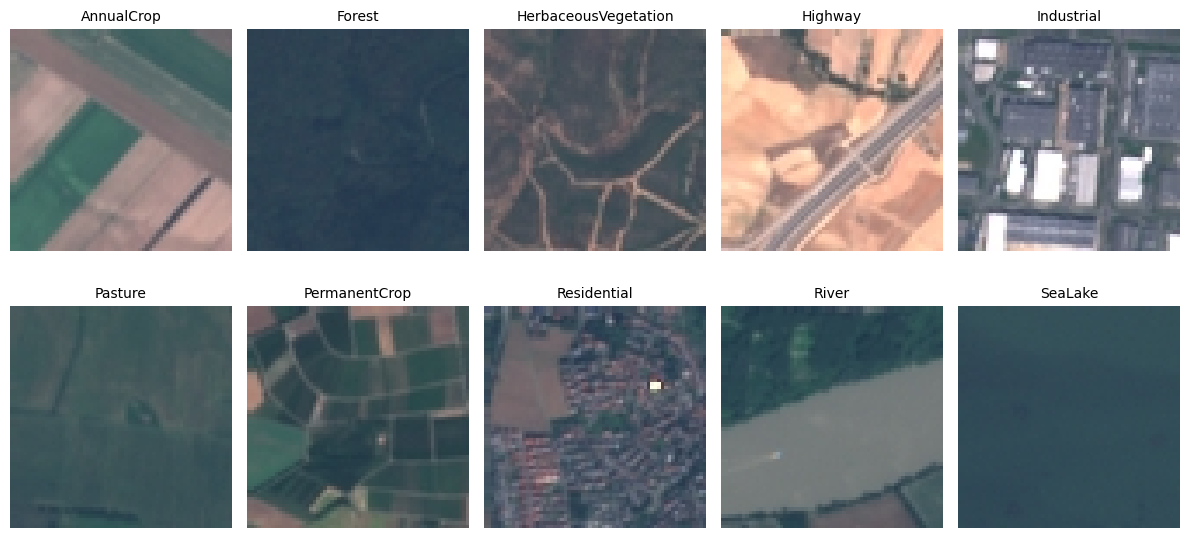

In [15]:
# visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, cls in enumerate(classes):
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]  
    img = Image.open(img_path)

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


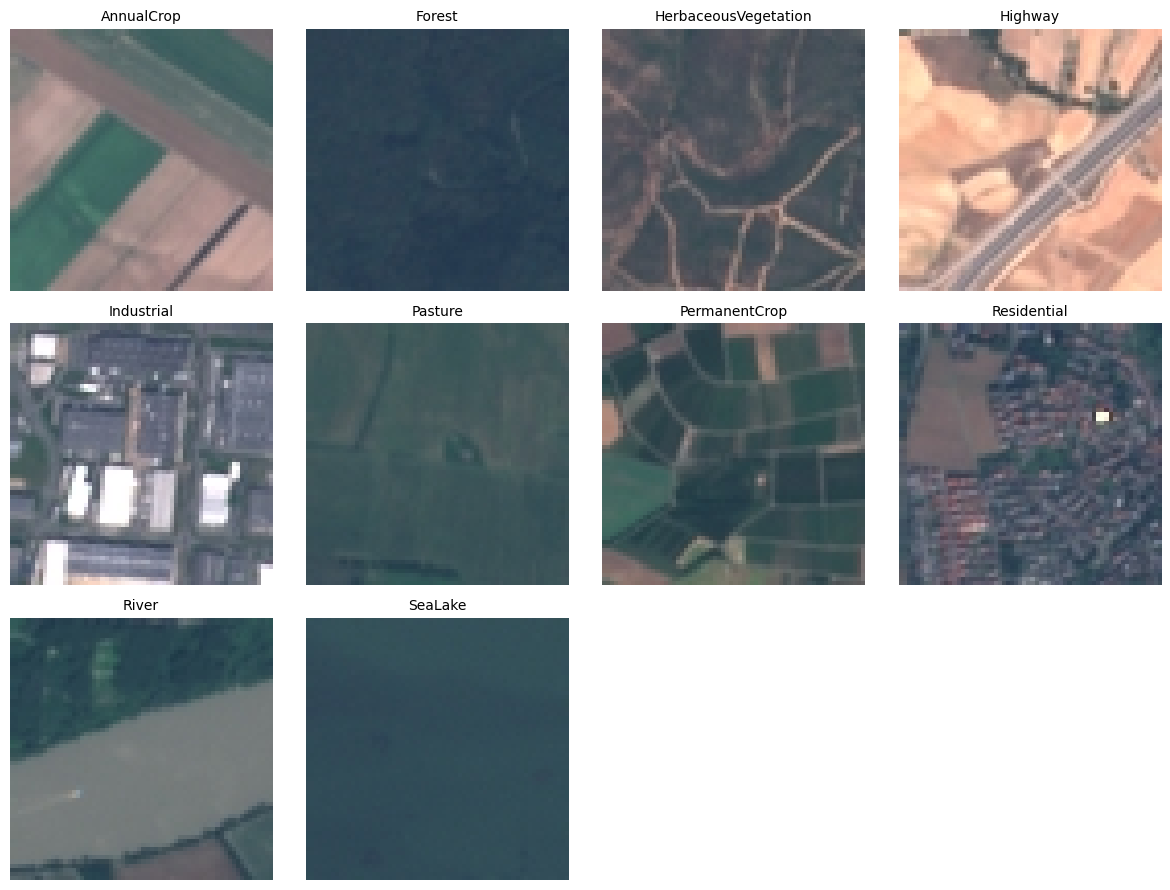

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i, cls in enumerate(classes[:12]):  # Ensure we only iterate up to 12 classes
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]  
    img = Image.open(img_path)

    ax = axes[i // 4, i % 4]  # 3 rows, 4 columns
    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

# Hide any extra subplots if classes < 12
for j in range(i + 1, 12):
    fig.delaxes(axes[j // 4, j % 4])

plt.tight_layout()
plt.show()

Many of them looks quite similar such that it would be difficult to be classified for also for a human.

At the moment, "Highway" and "River" looks like may be confused, as well as the "Residential" and "Industrial" classes or the "AnnualCrop" and "Pasture".

## CLIP: Zero-Shot Classification with Foundation Models
In this section, we implement zero-shot classification using **CLIP** to classify EuroSAT satellite images without dataset-specific training.  

We start by defining a function that classifies a single image, ensuring efficiency and flexibility. Then, we apply it to a single class before running it on the entire dataset to evaluate performance across all land cover types.  

To determine the best approach, we test four configurations, varying image rescaling and prompting to analyze their impact on classification accuracy.


In [17]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [18]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
print("Device: ", device)
clip_model.to(device)

Device:  mps


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [134]:
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Path to the dataset folder containing subfolders (each representing a class).
            classes (list, optional): List of class names to use. If None, all classes in root_dir are used.
        """
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []

        # If classes are not provided, infer from directory structure
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        # Collect all image paths and labels
        for cls in classes:
            class_dir = os.path.join(root_dir, cls)
            if os.path.isdir(class_dir):  # Ensure it's a directory
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        return img_path, label

    def get_class_subset(self, class_name):
        """Returns a subset of the dataset containing only images of the given class."""
        if class_name not in self.class_to_idx:
            raise ValueError(f"Class '{class_name}' not found in dataset. Available classes: {classes}")

        class_idx = self.class_to_idx[class_name]
        subset_indices = [i for i, label in enumerate(self.labels) if label == class_idx]

        # Create a subset of the dataset
        subset = [(self.image_paths[i], self.labels[i]) for i in subset_indices]
        return subset


In [132]:
dataset = ImageDataset(dataset_path, classes)  # root folder containing 10 subfolders
print(len(dataset))  # Total number of images

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

27000


### Single Image Classification 
We define a function that loads CLIP once and allows for customization:  
- **Resizing**: Optional rescaling to 224x224, CLIP’s expected input size.  
- **Prompting**: Either `"A satellite image of <class>"` or just the class name.  
- **Output Format**: Return either the best class or all probabilities for deeper analysis.  

These options allow us to test four setups, combining different prompts and rescaling choices to evaluate their impact on classification accuracy.


In [160]:
def classify_images_clip(
    image_paths, 
    class_names, 
    full_prompt=True,  # "default" (uses "A satellite image of"), "none" (just class name)
    rescaling=False,  # Whether to rescale image to CLIP’s expected 224x224
    return_all=False,  # If True, return all class probabilities; else return best class
):
    """
    Classifies a single image using CLIP in a zero-shot manner.

    Parameters:
    - image_path (str): Path to the image.
    - class_names (list): List of class labels.
    - prompt_type (str): "default" (adds 'A satellite image of') or "none" (just the class name).
    - rescale (bool): If True, rescale image to 224x224 (recommended for CLIP).
    - return_all (bool): If True, return all class probabilities; otherwise, return the best class.

    Returns:
    - If return_all=False: (str) Best class name.
    - If return_all=True: (dict) Class probabilities.
    """

    images = [Image.open(image_path).convert("RGB") for image_path in image_paths]
    if rescaling:
        images = [image.resize((224, 224)) for image in images]

    text_inputs = [f"A satellite image of {cls}" for cls in class_names] if full_prompt else class_names

    inputs = clip_processor(text=text_inputs, images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to GPU if available

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    return probs.argmax(dim=-1)

    class_probs = {class_names[i]: probs[0, i].item() for i in range(len(class_names))}

    if return_all:
        return class_probs
    else:
        return max(class_probs, key=class_probs.get)

In [136]:
image_path = "2750/Forest/Forest_100.jpg"
best_class_index = classify_images_clip([image_path], classes)
print(f"Predicted Class: {classes[best_class_index]}")

Predicted Class: Forest


### Single-Class Analysis  
Before testing the full dataset, we apply CLIP to one class (`SeaLake`).  

We expect some correct classifications, but also errors due to CLIP's lack of satellite-specific training. This helps identify potential challenges before scaling up.

In [118]:
test_class_name = "SeaLake"

In [159]:
def single_class_analysis(class_name, full_prompt=True, rescaling=False):
    class_subset = dataset.get_class_subset(class_name)
    class_dataloader = DataLoader(class_subset, batch_size=64, shuffle=False)

    true_labels = []
    predicted_labels = []


    for img_paths, labels in tqdm(class_dataloader, desc=f"Classifying {class_name} batches: ", leave=True):
        true_labels.extend(labels)

        predictions = classify_images_clip(img_paths, classes, full_prompt, rescaling).cpu()
        predicted_labels.extend(predictions)

    accuracy = accuracy_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))
    
    return accuracy, cm

Classifying SeaLake batches: 100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Zero-Shot Classification Accuracy for 'SeaLake': 19.07%


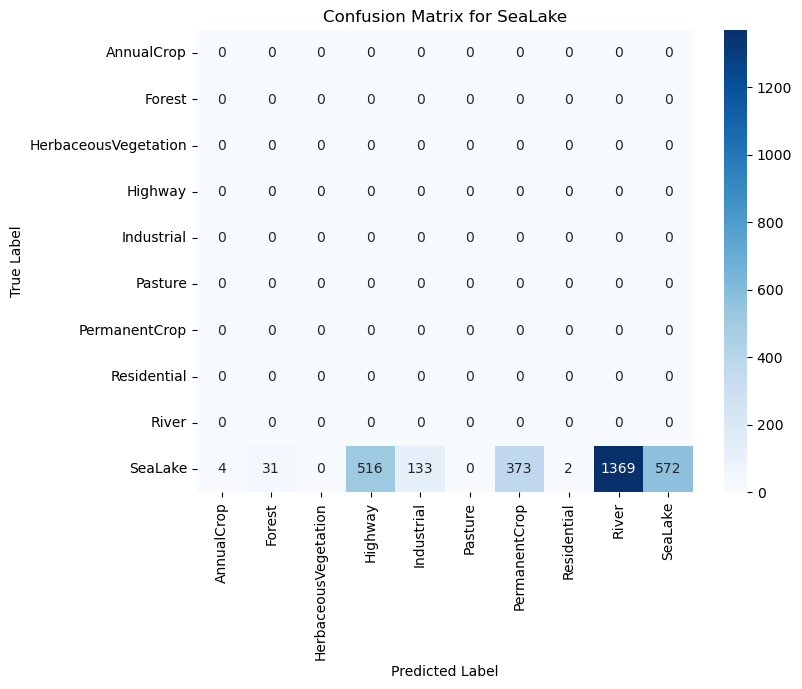

In [152]:
sealake_accuracy, sealake_cm = single_class_analysis(class_name=test_class_name, full_prompt=True)

print(f"Zero-Shot Classification Accuracy for '{test_class_name}': {sealake_accuracy * 100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(sealake_cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {test_class_name}")
plt.show()

### Whole Dataset Classification
We now classify the entire dataset using the four different configurations.  

By analyzing overall accuracy, per-class accuracy, and confusion matrices**, we aim to determine which approach works best for zero-shot land cover classification with CLIP.


In [158]:
def multi_class_analysis(full_prompt=True, rescaling=False):
    class_accuracies = {}
    class_cms = {}

    for eval_class in classes:
        class_accuracy, class_cm = single_class_analysis(eval_class, full_prompt, rescaling)

        class_accuracies[eval_class] = class_accuracy * 100
        class_cms[eval_class] = class_cm

    return class_accuracies, class_cms

#### 1) Full Prompt with Original Size

In [155]:
class_accuracies_1, class_cms_1 = multi_class_analysis(full_prompt=True)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:19<00:00,  2.47it/s]


In [157]:
overall_accuracy = np.mean(list(class_accuracies_1.values()))
# overall_cm = sum(list(class_cms_1.values()))

print(f"\nOverall Accuracy (Full Prompt + Original Size): {overall_accuracy:.2f}%\n")
# print("Accuracy per Class:")
# for cls, acc in class_accuracies_1.items():
#     print(f"  - {cls}: {acc:.2f}%")

# plt.figure(figsize=(10, 8))
# sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Full Prompt + Original Size)")
# plt.show()



Overall Accuracy (Full Prompt + Original Size): 38.29%



#### 2) Full-Prompt with Rescaling

In [162]:
class_accuracies_2, class_cms_2 = multi_class_analysis(full_prompt=True, rescaling=True)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:19<00:00,  2.43it/s]


In [164]:
overall_accuracy = np.mean(list(class_accuracies_2.values()))

print(f"\nOverall Accuracy (Full Prompt + Rescaled): {overall_accuracy:.2f}%\n")


Overall Accuracy (Full Prompt + Rescaled): 38.29%



#### 3) No Prompt with Original Size

In [165]:
class_accuracies_3, class_cms_3 = multi_class_analysis(full_prompt=False, rescaling=False)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.56it/s]


In [166]:
overall_accuracy = np.mean(list(class_accuracies_3.values()))

print(f"\nOverall Accuracy (No Prompt Context + Original Size): {overall_accuracy:.2f}%\n")


Overall Accuracy (No Prompt Context + Original Size): 35.18%



#### 4) No Prompt with Rescaling

In [167]:
class_accuracies_4, class_cms_4 = multi_class_analysis(full_prompt=False, rescaling=True)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:20<00:00,  2.28it/s]


In [168]:
overall_accuracy = np.mean(list(class_accuracies_4.values()))

print(f"\nOverall Accuracy (No Prompt Context + Original Size): {overall_accuracy:.2f}%\n")


Overall Accuracy (No Prompt Context + Original Size): 35.18%



#### Results Analysis

In [179]:
def compare_class_accuracies(acc_1, acc_2, label_1="Config 1", label_2="Config 2"):
    """
    Compare accuracy results from two different configurations.

    Parameters:
    - acc_1: Dictionary of class accuracies for first configuration.
    - acc_2: Dictionary of class accuracies for second configuration.
    - label_1: Label for first configuration (string).
    - label_2: Label for second configuration (string).
    """

    classes_sorted = sorted(acc_1.keys())
    acc_values_1 = [np.average([acc_1[cls] for cls in classes_sorted])] + [acc_1[cls] for cls in classes_sorted]
    acc_values_2 = [np.average([acc_2[cls] for cls in classes_sorted])] + [acc_2[cls] for cls in classes_sorted]

    x = np.arange(len(classes_sorted)+1)

    print(len(acc_values_1), len(x))

    plt.figure(figsize=(12, 5))
    plt.bar(x - 0.2, acc_values_1, width=0.4, label=label_1, alpha=0.7)
    plt.bar(x + 0.2, acc_values_2, width=0.4, label=label_2, alpha=0.7)

    plt.xticks(x,  ["Average"] + classes_sorted, rotation=45, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Comparison of Class Accuracies: {label_1} vs. {label_2}")
    plt.legend()
    plt.show()

    print(f"\n🔹 Accuracy Differences ({label_2} - {label_1}):")
    for cls in ["Average"] + classes_sorted:
        diff = acc_2[cls] - acc_1[cls]
        print(f"  - {cls}: {diff:.2f}% {'🔼' if diff > 0 else '🔽'}")

11 11


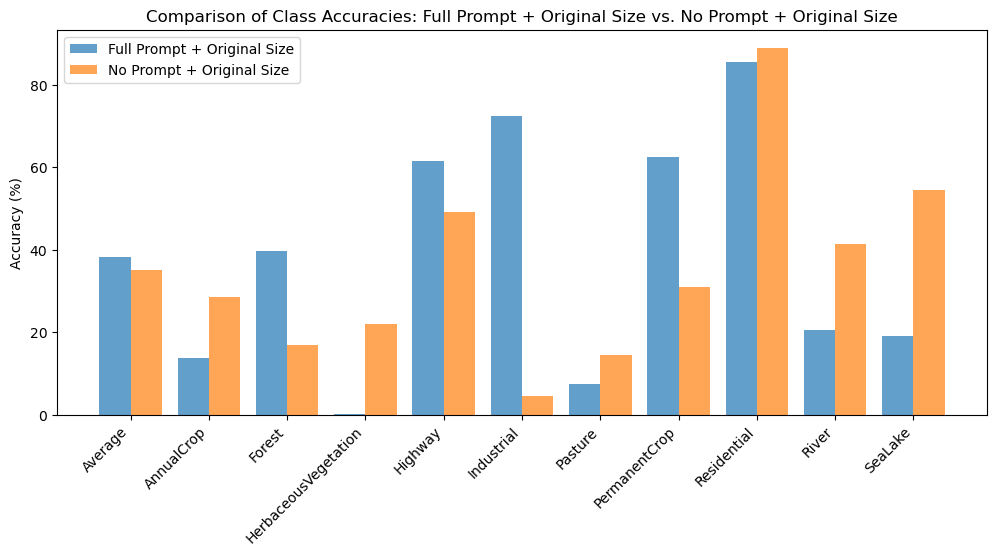


🔹 Accuracy Differences (No Prompt + Original Size - Full Prompt + Original Size):
  - AnnualCrop: 14.87% 🔼
  - Forest: -22.80% 🔽
  - HerbaceousVegetation: 21.77% 🔼
  - Highway: -12.60% 🔽
  - Industrial: -67.96% 🔽
  - Pasture: 7.15% 🔼
  - PermanentCrop: -31.36% 🔽
  - Residential: 3.40% 🔼
  - River: 20.96% 🔼
  - SeaLake: 35.53% 🔼


In [180]:
compare_class_accuracies(class_accuracies_1, class_accuracies_3, "Full Prompt + Original Size", "No Prompt + Original Size")

The results are quite interesting.

First thing we note is that resizing has no effect at all, mantaining the same exact prediction scores.7

Comparing instead the Full Prompt with just the class name, we see a slight improvement by 2 percentage point (with the Full Prompt).

What is curious is the fact that this improvement is not homogeneous at all.

Check for example "SeaLake" class. With the Full Prompt it has ha 19% accuracy, while with just the class name it goes up to 54.50%, totally against the average trend. Similar case for "HerbaceousVegetation" which goes from below 1% with the Full Prompt to 21.93%.

In the end only 4 classes actually improved their accuracy, but classes like "Industrial" improved almost of 70 percentage points, affecting a lot the general trend. 

We can state anyway that the Prompt choice actually affect a lot the overall performance, giving space for further improvements.